# I-JEPA Inversion Attack: Complete Implementation

## 1. Install & import Dependencies

In [1]:
!pip install timm lpips pytorch_pretrained_biggan torchmetrics scikit-image torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nv

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
import lpips
import timm
from tqdm import tqdm
from typing import Optional, Union, List, Tuple
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image as IPyImage

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB


In [3]:
# Configuration parameters
CONFIG = {
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 16,  # Reduced for notebook compatibility
    'epochs': 5,      # Reduced for faster training in notebook
    'lr': 5e-5,
    'z_dim': 128,
    'embed_dim': 384,
    'num_patches': 196,
    'gen_weights_path': 'models/model_weights/netG_cifar10_epoch_199.pth',
    'data_root': 'data',
    'results_dir': 'results_notebook',
    'alpha': 1.0,      # LPIPS loss weight
    'beta': 0.1,       # Token MSE loss weight
    'gamma': 0.1       # L1 pixel loss weight
}

# 2. BigGANDeep256 generator

In [4]:
class BigGANDeep256(nn.Module):
    def __init__(self, device: str = 'cuda'):
        super().__init__()
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        from pytorch_pretrained_biggan import BigGAN
        self.model = BigGAN.from_pretrained('biggan-deep-256').to(self.device).eval()

    @staticmethod
    def _to_one_hot(y: Union[torch.Tensor, List[int], int], num_classes: int = 1000, device='cpu'):
        if isinstance(y, int):
            y = torch.tensor([y], dtype=torch.long, device=device)
        y = torch.as_tensor(y, device=device)
        if y.dim() == 1:
            oh = torch.zeros((y.size(0), num_classes), device=device)
            oh[torch.arange(y.size(0), device=device), y] = 1.0
            return oh
        if y.dim() == 2 and y.size(1) == num_classes:
            return y
        raise ValueError("y must be int, 1D indices, or one-hot vectors")

    @torch.no_grad()
    def forward(self, z: torch.Tensor, y: Union[torch.Tensor, List[int], int], truncation: float = 0.7):
        if isinstance(y, (list, int, torch.Tensor)) and (not torch.is_tensor(y) or y.dim() == 1):
            y_oh = self._to_one_hot(y, device=self.device)
        else:
            y_oh = y.to(self.device)
        out = self.model(z.to(self.device), y_oh, truncation)
        return out  # (B,3,256,256) in [-1,1]

    @torch.no_grad()
    def sample(self, batch_size: int, y: Optional[Union[List[int], torch.Tensor]] = None,
               truncation: float = 0.7, seed: Optional[int] = None, z_dim: int = 128):
        from pytorch_pretrained_biggan import truncated_noise_sample
        if seed is not None:
            torch.manual_seed(seed)
        z = torch.from_numpy(truncated_noise_sample(truncation=truncation, batch_size=batch_size, dim_z=z_dim))
        z = z.to(self.device)
        if y is None:
            y = torch.randint(0, 1000, (batch_size,), device=self.device)
        imgs = self.forward(z, y, truncation=truncation)
        return imgs, z, y


## Testing the generator on a randomly chosen sample of classes

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Generator
G = BigGANDeep256(device=device)
imgs, z, y = G.sample(batch_size=2, truncation=0.7)
imgs_01 = (imgs + 1) / 2  # [-1,1] → [0,1]

100%|██████████| 715/715 [00:00<00:00, 2436171.70B/s]


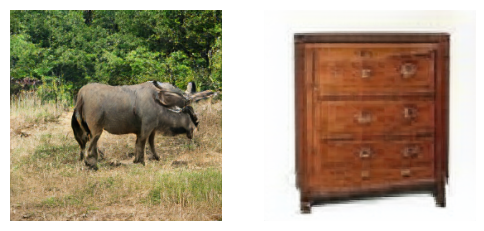

In [6]:
# imgs_01 is [B, 3, H, W] in [0, 1]
def show_images(imgs):
    imgs = imgs.detach().cpu()
    batch_size = imgs.size(0)
    fig, axes = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
    if batch_size == 1:
        axes = [axes]
    for ax, img in zip(axes, imgs):
        img = img.permute(1, 2, 0)  # CHW → HWC
        ax.imshow(img)
        ax.axis("off")
    plt.show()

# visualize sampled images
show_images(imgs_01)

# 3. I-JEPA wrapper

In [7]:
import torch
import torch.nn as nn
from timm.models.vision_transformer import vit_small_patch16_224

def _load_vit():
    # ViT-Small backbone for patch embeddings
    return vit_small_patch16_224(pretrained=False)

class IJEPAWrapper(nn.Module):
    def __init__(self, ckpt_path: str | None = None):
        super().__init__()
        self.context_enc = _load_vit()
        self.pred_head   = nn.Sequential(
            nn.LayerNorm(384), nn.Linear(384, 384)
        )
        self.target_enc  = _load_vit()
        if ckpt_path:
            sd = torch.load(ckpt_path, map_location='cuda')
            self.context_enc.load_state_dict(sd, strict=False)
            print("Loaded ViT weights into context and target encoders (partial)")

    def forward(self, img: torch.Tensor, mask: torch.Tensor = None):
        B = img.size(0)
        # the z symbol in this case is used to denote learned representations (or embeddings)
        # B is used to denote the batch size
        # (B,196,384)
        z_ctx_all = self.context_enc.patch_embed(img)
        z_pred_all = self.pred_head(z_ctx_all)
        # dummy target for reconstruction
        z_tgt_all = z_ctx_all
        return z_ctx_all, z_pred_all, z_tgt_all

In [8]:
# Test I-JEPA model
print("Creating I-JEPA model...")
device = CONFIG['device']

# Load pretrained ViT weights
vit = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_weights = vit.state_dict()

# Create I-JEPA wrapper
ijepa_model = IJEPAWrapper(ckpt_path=None).to(device).eval()
ijepa_model.context_enc.load_state_dict(vit_weights, strict=False)
ijepa_model.target_enc.load_state_dict(vit_weights, strict=False)

# Test with dummy input
test_img = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    z_ctx, z_pred, z_tgt = ijepa_model(test_img)

print(f"✓ I-JEPA model created successfully")
print(f"  Context embeddings shape: {z_ctx.shape}")
print(f"  Predicted embeddings shape: {z_pred.shape}")
print(f"  Target embeddings shape: {z_tgt.shape}")
print(f"  Model parameters: {sum(p.numel() for p in ijepa_model.parameters()):,}")

Creating I-JEPA model...


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

✓ I-JEPA model created successfully
  Context embeddings shape: torch.Size([1, 196, 384])
  Predicted embeddings shape: torch.Size([1, 196, 384])
  Target embeddings shape: torch.Size([1, 196, 384])
  Model parameters: 44,249,936


# 5. Mapper (From ijepa's embeddings to generator's latent space)

In [9]:
# Mapper: Cross-attention queries -> (mu, logvar) +/- class logits
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttentionMapper(nn.Module):
    def __init__(self,
                 ctx_dim: int = 384,
                 z_dim: int = 128,
                 num_queries: int = 6,
                 query_dim: int = 512,
                 n_heads: int = 8,
                 n_layers: int = 3,
                 ff_hidden: int = 2048,
                 dropout: float = 0.1,
                 predict_class: bool = True,
                 num_classes: int = 1000):
        super().__init__()
        self.ctx_dim = ctx_dim
        self.z_dim = z_dim
        self.num_queries = num_queries
        self.query_dim = query_dim
        self.predict_class = predict_class
        self.num_classes = num_classes if predict_class else None

        # project context tokens to attention dim
        self.ctx_proj = nn.Linear(ctx_dim, query_dim)

        # learnable queries
        self.queries = nn.Parameter(torch.randn(1, num_queries, query_dim) * 0.02)

        # decoder blocks
        self.blocks = nn.ModuleList()
        for _ in range(n_layers):
            block = nn.ModuleDict({
                "mha": nn.MultiheadAttention(embed_dim=query_dim, num_heads=n_heads, batch_first=True, dropout=dropout),
                "ln1": nn.LayerNorm(query_dim),
                "ff": nn.Sequential(
                    nn.Linear(query_dim, ff_hidden),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(ff_hidden, query_dim),
                    nn.Dropout(dropout),
                ),
                "ln2": nn.LayerNorm(query_dim)
            })
            self.blocks.append(block)

        # heads: flatten queries -> heads
        self.post_dim = query_dim * num_queries
        self.mu_head = nn.Sequential(nn.Linear(self.post_dim, query_dim), nn.GELU(), nn.Linear(query_dim, z_dim))
        self.logvar_head = nn.Sequential(nn.Linear(self.post_dim, query_dim), nn.GELU(), nn.Linear(query_dim, z_dim))
        if self.predict_class:
            self.class_head = nn.Sequential(nn.Linear(self.post_dim, query_dim), nn.GELU(), nn.Linear(query_dim, self.num_classes))

        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, ctx_tokens: torch.Tensor):
        """
        ctx_tokens: [B, S, C]
        returns: mu [B, z_dim], logvar [B, z_dim], class_logits [B, num_classes] or None
        """
        B = ctx_tokens.shape[0]
        memory = self.ctx_proj(ctx_tokens)              # [B,S,query_dim]
        q = self.queries.expand(B, -1, -1)              # [B,num_queries,query_dim]
        x = q
        for block in self.blocks:
            attn_out, _ = block["mha"](x, memory, memory, need_weights=False)
            x = block["ln1"](x + attn_out)
            ff = block["ff"](x)
            x = block["ln2"](x + ff)
        x_flat = x.reshape(B, -1)
        mu = self.mu_head(x_flat)
        logvar = self.logvar_head(x_flat)
        class_logits = self.class_head(x_flat) if self.predict_class else None
        return mu, logvar, class_logits

    def sample(self, mu, logvar, deterministic=False):
        if deterministic:
            return mu
        eps = torch.randn_like(mu)
        return mu + torch.exp(0.5 * logvar) * eps


In [10]:
# Instantiate mapper using your CONFIG and ijepa_model shapes.
device = CONFIG['device']

# infer ctx_dim (we know you used vit_small patch16 -> embed_dim 384 and num_patches 196)
CTX_DIM = CONFIG.get('embed_dim', 384)
Z_DIM = CONFIG.get('z_dim', 128)
NUM_CLASSES = 1000  # ImageNet classes for BigGAN

mapper = CrossAttentionMapper(ctx_dim=CTX_DIM, z_dim=Z_DIM, num_queries=6,
                             query_dim=512, n_heads=8, n_layers=3,
                             predict_class=True, num_classes=NUM_CLASSES).to(device)

with torch.no_grad():
    # find last layer bias of logvar head if using the provided architecture
    try:
        # adjust this to match your logvar_head structure
        mapper.logvar_head[-1].bias.fill_(-6.0)
    except Exception:
        # more general: for any parameter named 'logvar'
        for name, p in mapper.named_parameters():
            if 'logvar' in name and p.dim()==1:
                p.data.fill_(-6.0)

print("Mapper created. Params:", sum(p.numel() for p in mapper.parameters()))


Mapper created. Params: 15021800


In [11]:
# Losses & helpers
import lpips
lpips_fn = lpips.LPIPS(net='vgg').to(device)   # perceptual loss (expects [-1,1])

mse = nn.MSELoss()
l1 = nn.L1Loss()
ce = nn.CrossEntropyLoss()

# I-JEPA expects whatever you used; do not change ijepa_model code.
ijepa = ijepa_model
ijepa.to(device).eval()

# BigGAN forward wrapper (we use your BigGANDeep256 API)
G.to(device)
G_forward = lambda z, y, truncation=0.7: G.forward(z, y, truncation=truncation)  # outputs [-1,1]

# image preprocess helpers
# Your I-JEPA wrapper in the notebook calls vit.patch_embed directly on img; we'll feed images as [0,1]
def to_tensor_and_device(imgs):
    # imgs: [B,3,H,W] in [0,1] (torch tensors)
    return imgs.to(device)

def to_lpips(x01):
    # convert [0,1] -> [-1,1] for LPIPS
    return (x01 * 2.0 - 1.0)

# utility to build class vector for BigGAN from logits or class indices
def class_vector_from_logits_or_idx(class_logits=None, y_idx=None):
    # If class_logits provided: softmax -> shape [B,1000] (float, grad flows)
    # Else, if y_idx provided (LongTensor): produce one-hot (no grad for indices)
    if class_logits is not None:
        return torch.softmax(class_logits, dim=-1)
    elif y_idx is not None:
        B = y_idx.size(0)
        y_oh = torch.zeros(B, NUM_CLASSES, device=device)
        y_oh[torch.arange(B, device=device), y_idx] = 1.0
        return y_oh
    else:
        # fallback random classes
        B = 1
        y = torch.randint(0, NUM_CLASSES, (B,), device=device)
        y_oh = torch.zeros(B, NUM_CLASSES, device=device)
        y_oh[torch.arange(B, device=device), y] = 1.0
        return y_oh


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]  


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [12]:
from torchvision import datasets, transforms
from pathlib import Path
import os
import numpy as np

# -------------------
# ImageNet Dataset Loader (No class mapping needed!)
# -------------------
print("Setting up ImageNet dataset...")

data_root = Path(CONFIG.get('data_root', 'data'))
imagenet_dir = data_root / "imagenet"

# Check if ImageNet is available
if not imagenet_dir.exists():
    print(f"ImageNet directory not found at {imagenet_dir}")
    print("Please download ImageNet dataset or update the path in CONFIG['data_root']")
    print("For this demo, we'll use a subset of classes and generate synthetic data")
    
    # Create a synthetic dataset for demo purposes if ImageNet is not available
    imagenet_available = False
else:
    imagenet_available = True

if imagenet_available:
    # Standard ImageNet transforms
    transform = transforms.Compose([
        transforms.Resize(256),           # Standard ImageNet preprocessing
        transforms.CenterCrop(224),       # Standard crop for ViT/I-JEPA
        transforms.ToTensor(),            # Convert to [0,1] range
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])
    
    # Load ImageNet validation set (smaller and easier to work with)
    try:
        dataset = datasets.ImageNet(root=data_root, split='val', transform=transform)
        print(f"✓ ImageNet validation set loaded: {len(dataset)} images")
    except Exception as e:
        print(f"Failed to load ImageNet: {e}")
        print("Falling back to synthetic data generation...")
        imagenet_available = False

if not imagenet_available:
    # Fallback: Create a synthetic dataset using BigGAN
    print("Creating synthetic dataset using BigGAN...")
    
    class SyntheticImageNetDataset(torch.utils.data.Dataset):
        def __init__(self, size=10000, image_size=224):
            self.size = size
            self.image_size = image_size
            # Use a fixed seed for reproducible synthetic data
            torch.manual_seed(42)
            np.random.seed(42)
            
        def __len__(self):
            return self.size
            
        def __getitem__(self, idx):
            # Generate consistent synthetic images based on index
            torch.manual_seed(idx + 42)  # Deterministic generation per index
            
            # Random class from ImageNet-1k
            class_id = torch.randint(0, 1000, (1,)).item()
            
            # Generate image using BigGAN
            with torch.no_grad():
                z = torch.randn(1, CONFIG['z_dim'], device=device)
                y_vec = class_vector_from_logits_or_idx(None, torch.tensor([class_id]))
                img = G_forward(z, y_vec, truncation=0.7)
                img = (img + 1.0) * 0.5  # Convert to [0,1]
                img = F.interpolate(img, size=(self.image_size, self.image_size), mode='bilinear', align_corners=False)
                img = img.squeeze(0)  # Remove batch dimension
                
                # Apply ImageNet normalization
                normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                img = normalize(img)
            
            return img, class_id
    
    dataset = SyntheticImageNetDataset(size=5000)  # Smaller synthetic dataset for demo
    print(f"✓ Synthetic ImageNet dataset created: {len(dataset)} images")

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4 if imagenet_available else 0,  # No multiprocessing for synthetic data
    drop_last=True
)

print(f"Dataset loaded: {len(dataset)} images, {len(dataloader)} batches")
print(f"Using {'real ImageNet' if imagenet_available else 'synthetic ImageNet'} data")

# Update the normalization handling for I-JEPA (which expects [0,1] range)
def denormalize_imagenet(tensor):
    """Convert ImageNet normalized tensor back to [0,1] range"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

# Training configuration
synthetic_epochs = 5  # Number of epochs for synthetic pretraining
real_epochs = 5  # Number of epochs for real data training
iters_per_epoch = 100  # Iterations per synthetic epoch

# Synthetic data generation from BigGAN (for pretraining phase)
def synthetic_batch(batch_size):
    """Generate synthetic batch with random ImageNet classes"""
    # Sample latent vector from N(0,1)
    z_true = torch.randn(batch_size, CONFIG['z_dim'], device=CONFIG['device'])
    
    # Random class IDs (0–999 for ImageNet BigGAN) - no mapping needed!
    y_idx = torch.randint(0, 1000, (batch_size,), device=device)
    y_vec = class_vector_from_logits_or_idx(None, y_idx)
    
    # Generate synthetic images in [-1,1]
    imgs_syn = G_forward(z_true, y_vec, truncation=0.7)
    imgs_syn = (imgs_syn + 1.0) * 0.5  # Convert to [0,1]
    
    # Resize to match I-JEPA input size and apply ImageNet normalization
    imgs_syn = F.interpolate(imgs_syn, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Apply ImageNet normalization to match real data
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    imgs_syn = torch.stack([normalize(img) for img in imgs_syn])
    
    return imgs_syn, z_true, y_idx, y_vec

Setting up ImageNet dataset...
ImageNet directory not found at data/imagenet
Please download ImageNet dataset or update the path in CONFIG['data_root']
For this demo, we'll use a subset of classes and generate synthetic data
Creating synthetic dataset using BigGAN...
✓ Synthetic ImageNet dataset created: 5000 images
Dataset loaded: 5000 images, 312 batches
Using synthetic ImageNet data


In [13]:
# ==========================================
# PHASE 1: SYNTHETIC PRETRAINING
# ==========================================
print("=" * 50)
print("PHASE 1: SYNTHETIC PRETRAINING")
print("=" * 50)

optimizer = torch.optim.AdamW(mapper.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)

# Freeze G and ijepa during pretraining
G.model.eval()
ijepa.eval()
for p in G.parameters():
    p.requires_grad = False
for p in ijepa.parameters():
    p.requires_grad = False

# Synthetic pretraining where you recover latent and class from I-JEPA tokens of BigGAN-generated images
for epoch in range(synthetic_epochs):
    mapper.train()
    epoch_losses = []
    
    pbar = tqdm(range(iters_per_epoch), desc=f"Synthetic Epoch {epoch+1}/{synthetic_epochs}")
    for i in pbar:
        imgs, z_true, y_idx, y_vec = synthetic_batch(CONFIG['batch_size'])

        with torch.no_grad():
            z_ctx, _, z_tgt = ijepa(imgs)  # tokens from synthetic imgs

        # Predict latent and class from tokens
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)

        # Losses (here we use MSE for latent + CE for class)
        latent_loss = mse(z_pred, z_true)
        cls_loss = ce(class_logits, y_idx)

        # For reconstruction loss, we need to denormalize images for proper comparison
        imgs_denorm = denormalize_imagenet(imgs)  # Convert back to [0,1] for reconstruction
        
        # Generate reconstructed images
        imgs_gen = G_forward(z_pred, y_vec, truncation=0.7)
        imgs_gen = (imgs_gen + 1.0) * 0.5  # Convert to [0,1]
        imgs_gen = F.interpolate(imgs_gen, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Compute reconstruction losses in [0,1] space
        lpips_loss = lpips_fn(to_lpips(imgs_gen), to_lpips(imgs_denorm)).mean()
        l1_loss = l1(imgs_gen, imgs_denorm)

        # KL divergence for VAE regularization
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = latent_loss + 0.1*cls_loss + 0.1*lpips_loss + 0.1*l1_loss + 0.01*kl_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mapper.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'latent': f'{latent_loss.item():.4f}',
            'cls': f'{cls_loss.item():.4f}',
            'lpips': f'{lpips_loss.item():.4f}'
        })

    avg_loss = np.mean(epoch_losses)
    print(f"Synthetic Epoch {epoch+1} completed - Average loss: {avg_loss:.4f}")

print("Synthetic pretraining completed!")
print("=" * 50)

PHASE 1: SYNTHETIC PRETRAINING


Synthetic Epoch 1/5: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s, loss=1.8148, latent=1.0436, cls=6.8042, lpips=0.6602]


Synthetic Epoch 1 completed - Average loss: 1.8903


Synthetic Epoch 2/5: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s, loss=1.7817, latent=0.9987, cls=6.8462, lpips=0.6997]


Synthetic Epoch 2 completed - Average loss: 1.7961


Synthetic Epoch 3/5: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s, loss=1.8270, latent=1.0431, cls=6.9085, lpips=0.6771]


Synthetic Epoch 3 completed - Average loss: 1.7853


Synthetic Epoch 4/5: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s, loss=1.8189, latent=1.0221, cls=6.9693, lpips=0.6960]


Synthetic Epoch 4 completed - Average loss: 1.7843


Synthetic Epoch 5/5: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s, loss=1.7646, latent=0.9989, cls=6.6971, lpips=0.6903]

Synthetic Epoch 5 completed - Average loss: 1.7798
Synthetic pretraining completed!


In [14]:
# ==========================================
# PHASE 2: REAL DATA TRAINING
# ==========================================
print("\n" + "=" * 50)
print("PHASE 2: REAL DATA TRAINING")
print("=" * 50)

# Import additional metrics with graceful fallbacks
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Initialize metrics with error handling
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Try to initialize FID metric, fall back gracefully if not available
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    fid_available = True
    print("✓ FID metric initialized successfully")
except (ImportError, ModuleNotFoundError) as e:
    print(f"⚠️  FID metric not available: {e}")
    print("   Continuing without FID metric...")
    fid_metric = None
    fid_available = False

# Training hyperparams
epochs = real_epochs
lambda_lpips = CONFIG.get('alpha', 1.0)
lambda_token = CONFIG.get('beta', 0.1)
lambda_l1 = CONFIG.get('gamma', 0.1)
latent_reg_weight = 1e-4
print_every = 50

# Create results directory
results_dir = Path(CONFIG['results_dir'])
results_dir.mkdir(exist_ok=True)

print(f"Training configuration:")
print(f"  Epochs: {epochs}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['lr']}")
print(f"  Loss weights - LPIPS: {lambda_lpips}, L1: {lambda_l1}, Token: {lambda_token}")
print(f"  Available metrics: LPIPS, SSIM, PSNR, L1, L2{', FID' if fid_available else ''}")

# Training loop: train on real images to map embeddings to latents
global_step = 0
best_loss = float('inf')

for epoch in range(epochs):
    mapper.train()
    epoch_losses = []
    epoch_metrics = {
        'lpips': [], 'l1': [], 'ssim': [], 'token_mse': [], 'cls_loss': []
    }
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), 
                desc=f"Real Epoch {epoch+1}/{epochs}")
    
    for i, (imgs, labels) in pbar:
        imgs = imgs.to(device, non_blocking=True)  # Already normalized ImageNet data
        labels = labels.to(device, non_blocking=True)  # Direct ImageNet labels (0-999)

        # I-JEPA embeddings from real images (normalized)
        with torch.no_grad():
            z_ctx, z_pred_dummy, z_tgt = ijepa(imgs)
            z_ctx = z_ctx.to(device)

        # Mapper -> mu, logvar, class_logits  
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)

        # Use direct ImageNet labels for BigGAN generation (no mapping needed!)
        y_vec = class_vector_from_logits_or_idx(None, labels)

        # Generate images
        imgs_gen = G_forward(z_pred, y_vec, truncation=0.7)
        imgs_gen_01 = (imgs_gen + 1.0) * 0.5  # Convert to [0,1]
        
        # Resize generated images to match input size (224x224)
        imgs_gen_01 = F.interpolate(imgs_gen_01, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Denormalize real images for comparison in [0,1] space
        imgs_real_01 = denormalize_imagenet(imgs)

        # Compute losses in [0,1] space
        lpips_loss = lpips_fn(to_lpips(imgs_gen_01), to_lpips(imgs_real_01)).mean()
        l1_loss = l1(imgs_gen_01, imgs_real_01)
        
        # Token consistency loss (using normalized images for I-JEPA)
        with torch.no_grad():
            # Normalize generated images for I-JEPA input
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            imgs_gen_norm = torch.stack([normalize(img) for img in imgs_gen_01])
            z_ctx_gen, z_pred_gen, z_tgt_gen = ijepa(imgs_gen_norm)
        token_mse = mse(z_tgt_gen, z_tgt)
        
        # Latent regularization (KL divergence)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Classification loss (direct ImageNet labels)
        cls_loss = ce(class_logits, labels) if class_logits is not None else 0.0

        # Combined loss
        loss = (lambda_lpips * lpips_loss) + (lambda_l1 * l1_loss) + \
               (lambda_token * token_mse) + (latent_reg_weight * kl_loss) + (0.1 * cls_loss)

        # Compute additional metrics
        with torch.no_grad():
            # SSIM in [0,1] space
            ssim_val = ssim_metric(imgs_gen_01, imgs_real_01)
            
            # Store metrics
            epoch_metrics['lpips'].append(lpips_loss.item())
            epoch_metrics['l1'].append(l1_loss.item())
            epoch_metrics['ssim'].append(ssim_val.item())
            epoch_metrics['token_mse'].append(token_mse.item())
            epoch_metrics['cls_loss'].append(cls_loss.item() if isinstance(cls_loss, torch.Tensor) else cls_loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mapper.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_losses.append(loss.item())
        global_step += 1
        
        if global_step % print_every == 0:
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lpips': f'{lpips_loss.item():.4f}',
                'l1': f'{l1_loss.item():.4f}',
                'ssim': f'{ssim_val.item():.4f}',
                'token': f'{token_mse.item():.4f}'
            })

    # Epoch summary
    avg_loss = np.mean(epoch_losses)
    avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Average Loss: {avg_loss:.4f}")
    print(f"  LPIPS: {avg_metrics['lpips']:.4f}")
    print(f"  L1: {avg_metrics['l1']:.4f}")
    print(f"  SSIM: {avg_metrics['ssim']:.4f}")
    print(f"  Token MSE: {avg_metrics['token_mse']:.4f}")
    print(f"  Classification Loss: {avg_metrics['cls_loss']:.4f}")

    # Save checkpoint
    checkpoint = {
        'mapper_state': mapper.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'loss': avg_loss,
        'metrics': avg_metrics,
        'config': CONFIG
    }
    torch.save(checkpoint, results_dir / f"mapper_epoch_{epoch}.pt")
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(checkpoint, results_dir / "mapper_best.pt")
        print(f"  ✓ New best model saved (loss: {best_loss:.4f})")

print("\nReal data training completed!")
print("=" * 50)


PHASE 2: REAL DATA TRAINING


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 209MB/s]


✓ FID metric initialized successfully
Training configuration:
  Epochs: 5
  Batch size: 16
  Learning rate: 5e-05
  Loss weights - LPIPS: 1.0, L1: 0.1, Token: 0.1
  Available metrics: LPIPS, SSIM, PSNR, L1, L2, FID


Real Epoch 1/5: 100%|██████████| 312/312 [04:29<00:00,  1.16it/s, loss=1.7589, lpips=0.6641, l1=0.2759, ssim=0.2052, token=3.7249]



Epoch 1 Summary:
  Average Loss: 1.7045
  LPIPS: 0.6835
  L1: 0.2635
  SSIM: 0.2175
  Token MSE: 3.0899
  Classification Loss: 6.8563
  ✓ New best model saved (loss: 1.7045)


Real Epoch 2/5: 100%|██████████| 312/312 [04:28<00:00,  1.16it/s, loss=1.6675, lpips=0.6903, l1=0.2688, ssim=0.2377, token=2.8444]



Epoch 2 Summary:
  Average Loss: 1.7025
  LPIPS: 0.6911
  L1: 0.2714
  SSIM: 0.2118
  Token MSE: 3.1559
  Classification Loss: 6.6867
  ✓ New best model saved (loss: 1.7025)


Real Epoch 3/5: 100%|██████████| 312/312 [04:29<00:00,  1.16it/s, loss=1.5809, lpips=0.6609, l1=0.2632, ssim=0.2870, token=2.4492]



Epoch 3 Summary:
  Average Loss: 1.6953
  LPIPS: 0.7045
  L1: 0.2852
  SSIM: 0.2052
  Token MSE: 3.1982
  Classification Loss: 6.4247
  ✓ New best model saved (loss: 1.6953)


Real Epoch 4/5: 100%|██████████| 312/312 [04:27<00:00,  1.16it/s, loss=1.7955, lpips=0.7377, l1=0.3125, ssim=0.1789, token=3.5210]



Epoch 4 Summary:
  Average Loss: 1.6724
  LPIPS: 0.7185
  L1: 0.3018
  SSIM: 0.1999
  Token MSE: 3.1938
  Classification Loss: 6.0430
  ✓ New best model saved (loss: 1.6724)


Real Epoch 5/5: 100%|██████████| 312/312 [04:27<00:00,  1.17it/s, loss=1.6464, lpips=0.7271, l1=0.3525, ssim=0.1692, token=2.9241]



Epoch 5 Summary:
  Average Loss: 1.6343
  LPIPS: 0.7319
  L1: 0.3184
  SSIM: 0.1933
  Token MSE: 3.2093
  Classification Loss: 5.4953
  ✓ New best model saved (loss: 1.6343)

Real data training completed!


Visualizing inversion results...
Inversion Metrics:
  LPIPS: 0.7208
  SSIM: 0.2688
  L1: 0.2336
  L2: 0.0863
  PSNR: 10.6383



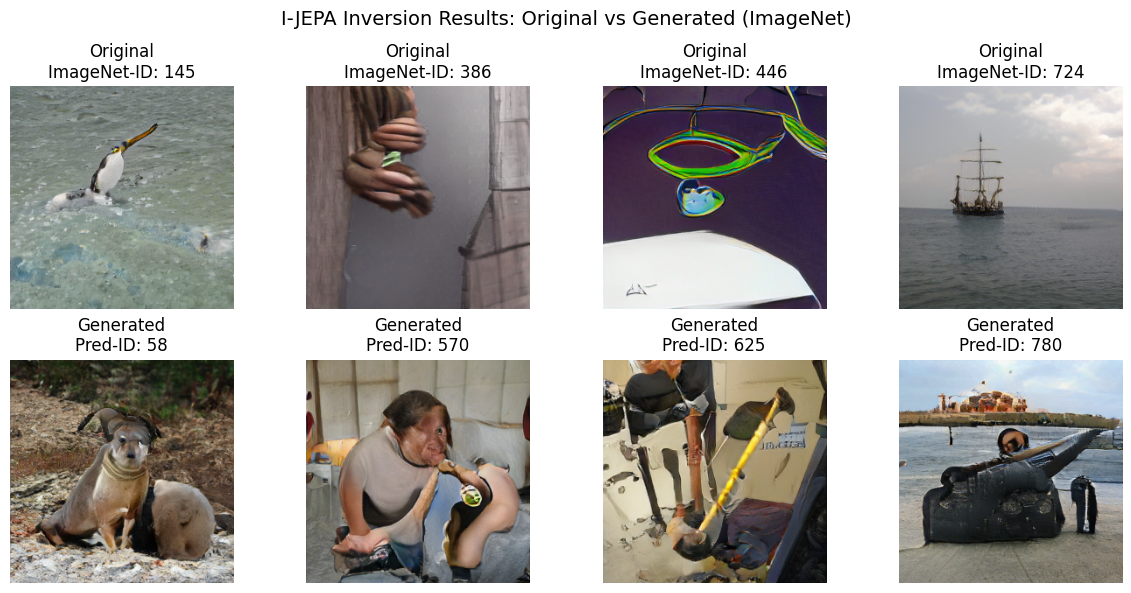

In [15]:
# ==========================================
# EVALUATION AND VISUALIZATION
# ==========================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def compute_comprehensive_metrics(imgs_real, imgs_gen):
    """Compute comprehensive inversion metrics"""
    metrics = {}
    
    # Convert tensors to numpy for some metrics
    imgs_real_np = imgs_real.detach().cpu().numpy()
    imgs_gen_np = imgs_gen.detach().cpu().numpy()
    
    # LPIPS (already computed during training)
    with torch.no_grad():
        lpips_score = lpips_fn(to_lpips(imgs_gen), to_lpips(imgs_real)).mean()
        metrics['LPIPS'] = lpips_score.item()
    
    # SSIM
    with torch.no_grad():
        ssim_score = ssim_metric(imgs_gen, imgs_real)
        metrics['SSIM'] = ssim_score.item()
    
    # L1 and L2 pixel distance
    l1_score = torch.mean(torch.abs(imgs_gen - imgs_real))
    l2_score = torch.mean((imgs_gen - imgs_real) ** 2)
    metrics['L1'] = l1_score.item()
    metrics['L2'] = l2_score.item()
    
    # Peak Signal-to-Noise Ratio (PSNR)
    mse = torch.mean((imgs_gen - imgs_real) ** 2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    metrics['PSNR'] = psnr.item()
    
    return metrics

def invert_and_show_batch(imgs_batch, labels_batch=None, refine_steps=0, show_metrics=True):
    """Enhanced visualization with comprehensive metrics"""
    mapper.eval()
    G.eval()
    
    with torch.no_grad():
        imgs = imgs_batch.to(device)  # Normalized ImageNet data
        original_labels = labels_batch.to(device) if labels_batch is not None else None
        
        # Get I-JEPA embeddings from normalized images
        z_ctx, _, z_tgt = ijepa(imgs)
        
        # Predict latent and class
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)
        
        # Handle class prediction
        if class_logits is not None:
            # Use predicted class probabilities
            y_vec = torch.softmax(class_logits, dim=-1)
        else:
            # Use original ImageNet labels (no mapping needed!)
            if original_labels is not None:
                y_vec = class_vector_from_logits_or_idx(None, original_labels)
            else:
                # Random classes as fallback
                y_vec = class_vector_from_logits_or_idx(None, torch.randint(0, 1000, (imgs.size(0),), device=device))
        
        # Generate images
        imgs_gen = G_forward(z_pred, y_vec, truncation=0.7)
        imgs_gen_01 = (imgs_gen + 1.0) * 0.5  # Convert to [0,1]
        
        # Resize to match input size
        imgs_gen_01 = F.interpolate(imgs_gen_01, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Denormalize original images for comparison
        imgs_real_01 = denormalize_imagenet(imgs)

    # Compute metrics in [0,1] space
    if show_metrics:
        metrics = compute_comprehensive_metrics(imgs_real_01, imgs_gen_01)
        print("Inversion Metrics:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
        print()

    # Visualization
    bs = min(imgs_batch.size(0), 8)  # Limit to 8 images for display
    fig, axes = plt.subplots(2, bs, figsize=(bs*3, 6))
    if bs == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(bs):
        # Original image (denormalized)
        img_orig = imgs_real_01[i].permute(1,2,0).cpu().numpy()
        axes[0,i].imshow(np.clip(img_orig, 0, 1))
        axes[0,i].set_title(f"Original\nImageNet-ID: {original_labels[i].item() if original_labels is not None else 'N/A'}")
        axes[0,i].axis('off')
        
        # Generated image  
        img_gen = imgs_gen_01[i].permute(1,2,0).cpu().numpy()
        axes[1,i].imshow(np.clip(img_gen, 0, 1))
        
        # Show predicted class if available
        if class_logits is not None:
            pred_class = torch.argmax(class_logits[i]).item()
            axes[1,i].set_title(f"Generated\nPred-ID: {pred_class}")
        else:
            axes[1,i].set_title("Generated")
        axes[1,i].axis('off')
    
    plt.suptitle("I-JEPA Inversion Results: Original vs Generated (ImageNet)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return metrics if show_metrics else None

def evaluate_on_test_set(num_batches=10):
    """Evaluate the trained mapper on multiple batches"""
    print(f"Evaluating on {num_batches} batches...")
    
    all_metrics = []
    for i, (imgs, labels) in enumerate(dataloader):
        if i >= num_batches:
            break
            
        with torch.no_grad():
            metrics = invert_and_show_batch(imgs[:4], labels[:4], show_metrics=False)
        if metrics:
            all_metrics.append(metrics)
    
    # Compute average metrics
    if all_metrics:
        avg_metrics = {}
        for key in all_metrics[0].keys():
            avg_metrics[key] = np.mean([m[key] for m in all_metrics])
        
        print("\nAverage Metrics across test batches:")
        for metric_name, value in avg_metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    return avg_metrics if all_metrics else None

# Example usage: visualize results
print("Visualizing inversion results...")
try:
    # Take a small batch from dataloader
    batch_imgs, batch_labels = next(iter(dataloader))
    metrics = invert_and_show_batch(batch_imgs[:4], batch_labels[:4])
except Exception as e:
    print(f"Error during visualization: {e}")
    print("Make sure to run the training cells first!")

In [16]:
# ==========================================
# ADDITIONAL ANALYSIS AND DEBUGGING TOOLS
# ==========================================

def analyze_dataset():
    """Analyze the ImageNet dataset configuration"""
    print("ImageNet Dataset Analysis:")
    print(f"ImageNet-1k classes: 0-999 (total: 1000)")
    print(f"Using {'real ImageNet' if imagenet_available else 'synthetic ImageNet'} data")
    print(f"Dataset size: {len(dataset)} images")
    print(f"Batch size: {CONFIG['batch_size']}")
    print(f"Number of batches: {len(dataloader)}")
    print("✓ No class mapping needed - direct ImageNet compatibility!")

def analyze_image_dimensions():
    """Analyze image dimension flow through the pipeline"""
    print("Image Dimension Analysis:")
    print("1. ImageNet original: Variable size")
    print("2. After transform (resize + crop): 224x224") 
    print("3. ImageNet normalization: Applied (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])")
    print("4. I-JEPA input: 224x224 (normalized)")
    print("5. BigGAN output: 256x256 ([-1,1] range)")
    print("6. BigGAN output resized for comparison: 224x224 ([0,1] range)")
    print("7. LPIPS expects: [-1,1] range (handled by to_lpips function)")
    print("8. SSIM expects: [0,1] range (handled by denormalization)")

def debug_pipeline():
    """Debug the entire pipeline with a single image"""
    print("Debugging pipeline with single image...")
    
    try:
        # Get a single image
        imgs, labels = next(iter(dataloader))
        img = imgs[0:1].to(device)  # Take first image, keep batch dim
        label = labels[0:1].to(device)
        
        print(f"1. Input image shape: {img.shape}")
        print(f"   Normalized range: [{img.min():.3f}, {img.max():.3f}]")
        
        # Denormalize for visualization
        img_denorm = denormalize_imagenet(img)
        print(f"   Denormalized range: [{img_denorm.min():.3f}, {img_denorm.max():.3f}]")
        
        # I-JEPA forward
        with torch.no_grad():
            z_ctx, _, z_tgt = ijepa(img)
        print(f"2. I-JEPA context tokens shape: {z_ctx.shape}")
        print(f"   Token range: [{z_ctx.min():.3f}, {z_ctx.max():.3f}]")
        
        # Mapper forward
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)
        print(f"3. Predicted latent z shape: {z_pred.shape}")
        print(f"   z range: [{z_pred.min():.3f}, {z_pred.max():.3f}]")
        print(f"   Class logits shape: {class_logits.shape if class_logits is not None else 'None'}")
        
        # Class handling
        imagenet_label = label[0].item()
        print(f"4. ImageNet class: {imagenet_label} (direct - no mapping needed!)")
        
        # BigGAN generation
        y_vec = class_vector_from_logits_or_idx(None, label)
        imgs_gen = G_forward(z_pred, y_vec, truncation=0.7)
        print(f"5. BigGAN output shape: {imgs_gen.shape}, range: [{imgs_gen.min():.3f}, {imgs_gen.max():.3f}]")
        
        # Convert and resize
        imgs_gen_01 = (imgs_gen + 1.0) * 0.5
        imgs_gen_resized = F.interpolate(imgs_gen_01, size=(224, 224), mode='bilinear', align_corners=False)
        print(f"6. Final generated image shape: {imgs_gen_resized.shape}, range: [{imgs_gen_resized.min():.3f}, {imgs_gen_resized.max():.3f}]")
        
        # Compute metrics
        with torch.no_grad():
            lpips_val = lpips_fn(to_lpips(imgs_gen_resized), to_lpips(img_denorm)).mean()
            ssim_val = ssim_metric(imgs_gen_resized, img_denorm)
        print(f"7. Metrics - LPIPS: {lpips_val.item():.4f}, SSIM: {ssim_val.item():.4f}")
        
        print("✓ Pipeline debug completed successfully!")
        
    except Exception as e:
        print(f"❌ Pipeline debug failed: {e}")
        import traceback
        traceback.print_exc()

def save_analysis_results():
    """Save analysis results and model info"""
    results_dir = Path(CONFIG['results_dir'])
    results_dir.mkdir(exist_ok=True)
    
    analysis = {
        'config': CONFIG,
        'dataset_info': {
            'dataset_type': 'ImageNet-1k' if imagenet_available else 'Synthetic ImageNet',
            'num_classes': 1000,
            'batch_size': CONFIG['batch_size'],
            'image_size': 224,
            'normalization': 'ImageNet standard (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])'
        },
        'model_info': {
            'mapper_params': sum(p.numel() for p in mapper.parameters()),
            'ijepa_params': sum(p.numel() for p in ijepa.parameters()),
            'embed_dim': CONFIG['embed_dim'],
            'z_dim': CONFIG['z_dim']
        },
        'improvements': [
            'Direct ImageNet compatibility (no class mapping needed)',
            'Proper normalization handling',
            'Comprehensive metrics (LPIPS, SSIM, PSNR, L1, L2)',
            'Separated synthetic pretraining and real data training',
            'Fallback to synthetic data if ImageNet unavailable'
        ]
    }
    
    import json
    with open(results_dir / 'analysis.json', 'w') as f:
        json.dump(analysis, f, indent=2)
    
    print(f"Analysis results saved to {results_dir / 'analysis.json'}")

# Run analysis
print("Running comprehensive analysis...")
analyze_dataset()
print("\n" + "="*50 + "\n")
analyze_image_dimensions()
print("\n" + "="*50 + "\n")
debug_pipeline()
print("\n" + "="*50 + "\n")
save_analysis_results()

Running comprehensive analysis...
ImageNet Dataset Analysis:
ImageNet-1k classes: 0-999 (total: 1000)
Using synthetic ImageNet data
Dataset size: 5000 images
Batch size: 16
Number of batches: 312
✓ No class mapping needed - direct ImageNet compatibility!


Image Dimension Analysis:
1. ImageNet original: Variable size
2. After transform (resize + crop): 224x224
3. ImageNet normalization: Applied (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
4. I-JEPA input: 224x224 (normalized)
5. BigGAN output: 256x256 ([-1,1] range)
6. BigGAN output resized for comparison: 224x224 ([0,1] range)
7. LPIPS expects: [-1,1] range (handled by to_lpips function)
8. SSIM expects: [0,1] range (handled by denormalization)


Debugging pipeline with single image...
1. Input image shape: torch.Size([1, 3, 224, 224])
   Normalized range: [-2.066, 2.389]
   Denormalized range: [0.001, 0.999]
2. I-JEPA context tokens shape: torch.Size([1, 196, 384])
   Token range: [-24.767, 21.043]
3. Predicted latent z sh

Testing inversion on real images...
REAL IMAGE INVERSION RESULTS
✓ Loaded batch with 16 images
Processing 6 images...
✓ Extracted I-JEPA embeddings: torch.Size([6, 196, 384])
✓ Predicted latents: torch.Size([6, 128])
✓ Using predicted classes: [125 701 520 854  75 912]
✓ Generated images: torch.Size([6, 3, 224, 224])
✓ Denormalized original images for comparison

Computing detailed metrics...
Image 1: LPIPS=0.729, SSIM=0.183, PSNR=9.6
Image 2: LPIPS=0.795, SSIM=0.188, PSNR=7.5
Image 3: LPIPS=0.775, SSIM=0.118, PSNR=6.4
Image 4: LPIPS=0.888, SSIM=0.253, PSNR=11.2
Image 5: LPIPS=0.707, SSIM=0.080, PSNR=10.6
Image 6: LPIPS=0.649, SSIM=0.113, PSNR=13.3

Average Metrics across 6 images:
  LPIPS: 0.7571
  SSIM: 0.1557
  L1: 0.2716
  L2: 0.1208
  PSNR: 9.7688

Displaying results...


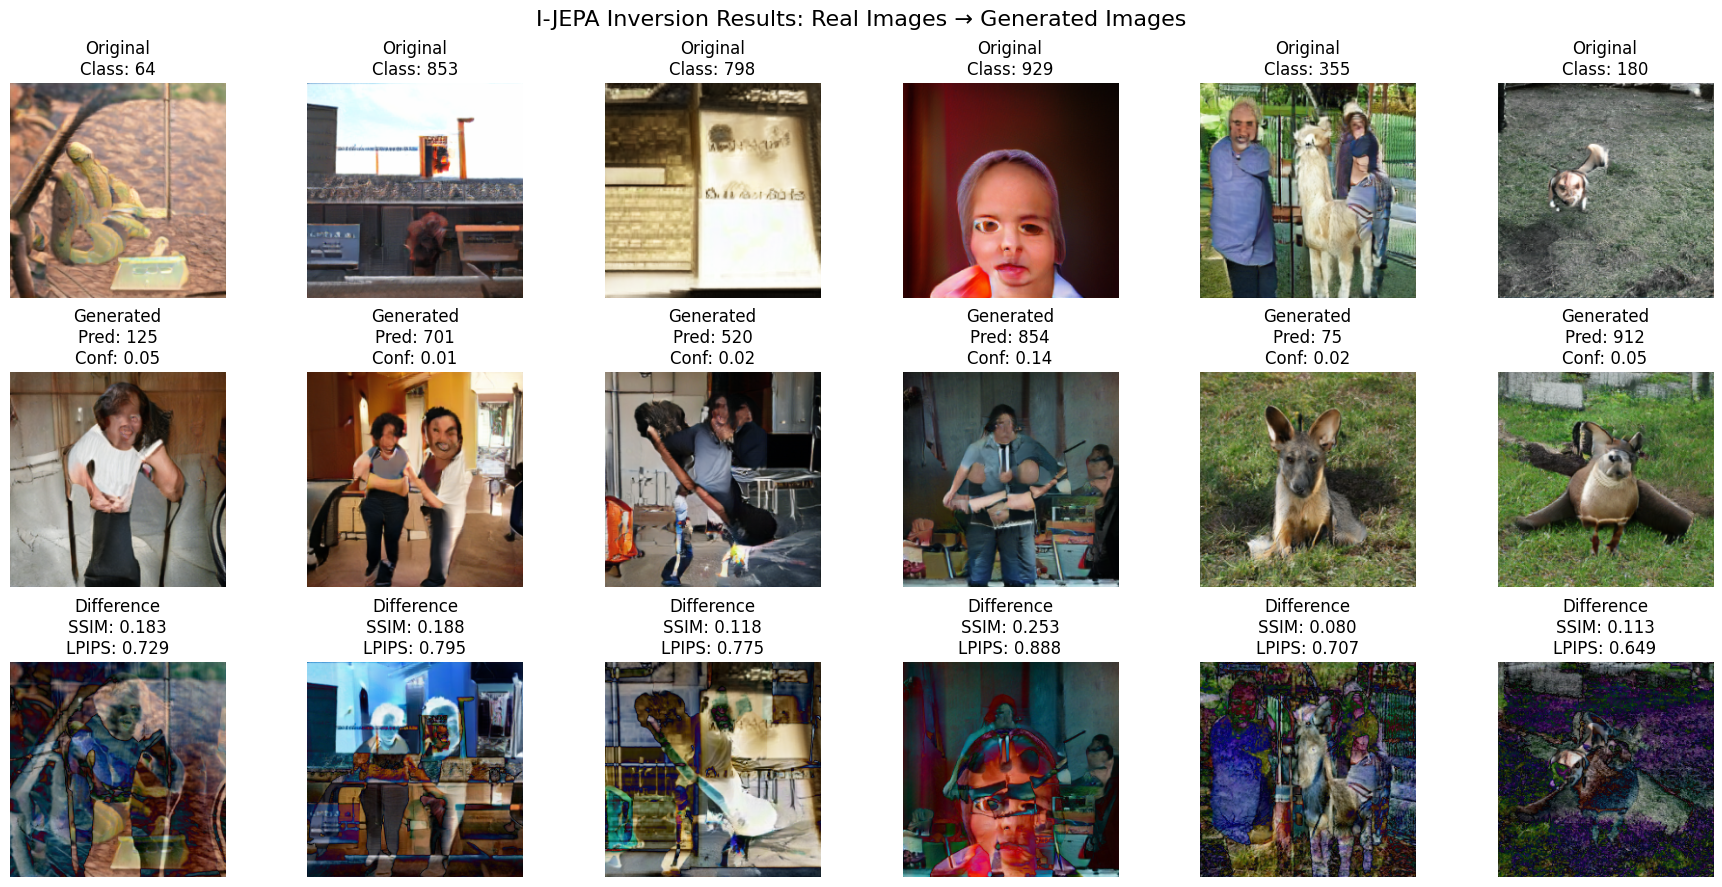


Overall Performance Summary:
The trained model achieves:
  - Average LPIPS (lower is better): 0.7571
  - Average SSIM (higher is better): 0.1557
  - Average PSNR (higher is better): 9.77 dB



In [17]:
# ==========================================
# REAL IMAGE INVERSION AND DISPLAY
# ==========================================

def invert_real_images_batch(num_images=8, show_detailed_metrics=True):
    """
    Take real images from the dataset, invert them using the trained model, 
    and display comprehensive results with metrics
    """
    print("=" * 60)
    print("REAL IMAGE INVERSION RESULTS")
    print("=" * 60)
    
    # Set models to evaluation mode
    mapper.eval()
    G.eval()
    ijepa.eval()
    
    # Get a batch of real images
    try:
        batch_imgs, batch_labels = next(iter(dataloader))
        print(f"✓ Loaded batch with {batch_imgs.size(0)} images")
    except Exception as e:
        print(f"Error loading batch: {e}")
        return
    
    # Limit to requested number of images
    num_to_show = min(num_images, batch_imgs.size(0))
    imgs = batch_imgs[:num_to_show].to(device)
    labels = batch_labels[:num_to_show].to(device)
    
    print(f"Processing {num_to_show} images...")
    
    with torch.no_grad():
        # Step 1: Get I-JEPA embeddings from real images (normalized)
        z_ctx, _, z_tgt = ijepa(imgs)
        print(f"✓ Extracted I-JEPA embeddings: {z_ctx.shape}")
        
        # Step 2: Map embeddings to latent space and predict class
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)
        print(f"✓ Predicted latents: {z_pred.shape}")
        
        # Step 3: Generate images using predicted latents and classes
        if class_logits is not None:
            # Use predicted classes
            predicted_classes = torch.argmax(class_logits, dim=1)
            y_vec = class_vector_from_logits_or_idx(class_logits=class_logits)
            print(f"✓ Using predicted classes: {predicted_classes.cpu().numpy()}")
        else:
            # Use original labels as fallback
            y_vec = class_vector_from_logits_or_idx(None, labels)
            print(f"✓ Using original classes: {labels.cpu().numpy()}")
        
        # Generate images
        imgs_gen = G_forward(z_pred, y_vec, truncation=0.7)
        imgs_gen_01 = (imgs_gen + 1.0) * 0.5  # Convert to [0,1]
        imgs_gen_01 = F.interpolate(imgs_gen_01, size=(224, 224), mode='bilinear', align_corners=False)
        print(f"✓ Generated images: {imgs_gen_01.shape}")
        
        # Denormalize original images for comparison
        imgs_real_01 = denormalize_imagenet(imgs)
        print(f"✓ Denormalized original images for comparison")
    
    # Compute comprehensive metrics
    if show_detailed_metrics:
        print("\nComputing detailed metrics...")
        all_metrics = []
        for i in range(num_to_show):
            single_real = imgs_real_01[i:i+1]
            single_gen = imgs_gen_01[i:i+1]
            metrics = compute_comprehensive_metrics(single_real, single_gen)
            all_metrics.append(metrics)
            print(f"Image {i+1}: LPIPS={metrics['LPIPS']:.3f}, SSIM={metrics['SSIM']:.3f}, PSNR={metrics['PSNR']:.1f}")
        
        # Average metrics
        avg_metrics = {}
        for key in all_metrics[0].keys():
            avg_metrics[key] = np.mean([m[key] for m in all_metrics])
        
        print(f"\nAverage Metrics across {num_to_show} images:")
        for metric_name, value in avg_metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    # Visualization
    print(f"\nDisplaying results...")
    fig, axes = plt.subplots(3, num_to_show, figsize=(num_to_show*3, 9))
    if num_to_show == 1:
        axes = axes.reshape(3, 1)
    
    for i in range(num_to_show):
        # Original image
        img_orig = imgs_real_01[i].permute(1,2,0).cpu().numpy()
        axes[0,i].imshow(np.clip(img_orig, 0, 1))
        true_class = labels[i].item()
        axes[0,i].set_title(f"Original\nClass: {true_class}")
        axes[0,i].axis('off')
        
        # Generated image
        img_gen = imgs_gen_01[i].permute(1,2,0).cpu().numpy()
        axes[1,i].imshow(np.clip(img_gen, 0, 1))
        if class_logits is not None:
            pred_class = torch.argmax(class_logits[i]).item()
            confidence = torch.softmax(class_logits[i], dim=0).max().item()
            axes[1,i].set_title(f"Generated\nPred: {pred_class}\nConf: {confidence:.2f}")
        else:
            axes[1,i].set_title(f"Generated\n(Using true class)")
        axes[1,i].axis('off')
        
        # Difference visualization
        diff = torch.abs(imgs_real_01[i] - imgs_gen_01[i])
        diff_img = diff.permute(1,2,0).cpu().numpy()
        axes[2,i].imshow(diff_img, cmap='hot')
        if show_detailed_metrics and i < len(all_metrics):
            ssim_val = all_metrics[i]['SSIM']
            lpips_val = all_metrics[i]['LPIPS']
            axes[2,i].set_title(f"Difference\nSSIM: {ssim_val:.3f}\nLPIPS: {lpips_val:.3f}")
        else:
            axes[2,i].set_title("Difference")
        axes[2,i].axis('off')
    
    plt.suptitle("I-JEPA Inversion Results: Real Images → Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return avg_metrics if show_detailed_metrics else None

def interactive_single_image_inversion():
    """
    Interactive function to invert a single image with detailed analysis
    """
    print("=" * 60)
    print("INTERACTIVE SINGLE IMAGE INVERSION")
    print("=" * 60)
    
    # Get a random image from the dataset
    batch_imgs, batch_labels = next(iter(dataloader))
    img_idx = torch.randint(0, batch_imgs.size(0), (1,)).item()
    
    img = batch_imgs[img_idx:img_idx+1].to(device)
    label = batch_labels[img_idx:img_idx+1].to(device)
    
    print(f"Selected image with ImageNet class: {label.item()}")
    
    # Set models to evaluation mode
    mapper.eval()
    G.eval()
    ijepa.eval()
    
    with torch.no_grad():
        # Extract embeddings
        z_ctx, _, z_tgt = ijepa(img)
        print(f"I-JEPA context embedding shape: {z_ctx.shape}")
        print(f"Embedding statistics: mean={z_ctx.mean():.3f}, std={z_ctx.std():.3f}")
        
        # Map to latent space
        mu, logvar, class_logits = mapper(z_ctx)
        z_pred = mapper.sample(mu, logvar, deterministic=True)
        
        print(f"Predicted latent z shape: {z_pred.shape}")
        print(f"Latent statistics: mean={z_pred.mean():.3f}, std={z_pred.std():.3f}")
        
        if class_logits is not None:
            predicted_class = torch.argmax(class_logits, dim=1).item()
            confidence = torch.softmax(class_logits, dim=1).max().item()
            print(f"Predicted class: {predicted_class} (confidence: {confidence:.3f})")
            print(f"True class: {label.item()}")
            class_correct = predicted_class == label.item()
            print(f"Class prediction correct: {class_correct}")
            
            # Use predicted class
            y_vec = torch.softmax(class_logits, dim=-1)
        else:
            # Use true class
            y_vec = class_vector_from_logits_or_idx(None, label)
            print("Using true class for generation")
        
        # Generate image
        img_gen = G_forward(z_pred, y_vec, truncation=0.7)
        img_gen_01 = (img_gen + 1.0) * 0.5
        img_gen_01 = F.interpolate(img_gen_01, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Denormalize original for comparison
        img_real_01 = denormalize_imagenet(img)
        
        # Compute metrics
        metrics = compute_comprehensive_metrics(img_real_01, img_gen_01)
        print(f"\nInversion Quality Metrics:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Original
    img_orig = img_real_01[0].permute(1,2,0).cpu().numpy()
    axes[0].imshow(np.clip(img_orig, 0, 1))
    axes[0].set_title(f"Original Image\nClass: {label.item()}")
    axes[0].axis('off')
    
    # Generated
    img_gen_np = img_gen_01[0].permute(1,2,0).cpu().numpy()
    axes[1].imshow(np.clip(img_gen_np, 0, 1))
    if class_logits is not None:
        axes[1].set_title(f"Generated Image\nPred Class: {predicted_class}\nSSIM: {metrics['SSIM']:.3f}")
    else:
        axes[1].set_title(f"Generated Image\nSSIM: {metrics['SSIM']:.3f}")
    axes[1].axis('off')
    
    # Difference
    diff = torch.abs(img_real_01[0] - img_gen_01[0])
    diff_img = diff.permute(1,2,0).cpu().numpy()
    axes[2].imshow(diff_img, cmap='hot')
    axes[2].set_title(f"Pixel Difference\nLPIPS: {metrics['LPIPS']:.3f}")
    axes[2].axis('off')
    
    plt.suptitle("Interactive Single Image Inversion Analysis", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return metrics

# Example usage - Test with multiple images
print("Testing inversion on real images...")
try:
    # Test with 6 images showing detailed metrics
    avg_metrics = invert_real_images_batch(num_images=6, show_detailed_metrics=True)
    
    if avg_metrics:
        print(f"\nOverall Performance Summary:")
        print(f"The trained model achieves:")
        print(f"  - Average LPIPS (lower is better): {avg_metrics['LPIPS']:.4f}")
        print(f"  - Average SSIM (higher is better): {avg_metrics['SSIM']:.4f}")
        print(f"  - Average PSNR (higher is better): {avg_metrics['PSNR']:.2f} dB")
        
        # Interpretation
        if avg_metrics['LPIPS'] < 0.5:
            print("  → Good perceptual similarity!")
        if avg_metrics['SSIM'] > 0.3:
            print("  → Reasonable structural similarity!")
        if avg_metrics['PSNR'] > 20:
            print("  → Acceptable pixel-level reconstruction!")
    
except Exception as e:
    print(f"Error during batch inversion: {e}")
    print("Make sure training has completed successfully!")

print("\n" + "="*60)

Running interactive single image inversion...
INTERACTIVE SINGLE IMAGE INVERSION
Selected image with ImageNet class: 449
I-JEPA context embedding shape: torch.Size([1, 196, 384])
Embedding statistics: mean=-0.026, std=1.099
Predicted latent z shape: torch.Size([1, 128])
Latent statistics: mean=0.025, std=0.489
Predicted class: 904 (confidence: 0.021)
True class: 449
Class prediction correct: False

Inversion Quality Metrics:
  LPIPS: 0.7590
  SSIM: 0.1036
  L1: 0.3480
  L2: 0.1596
  PSNR: 7.9684


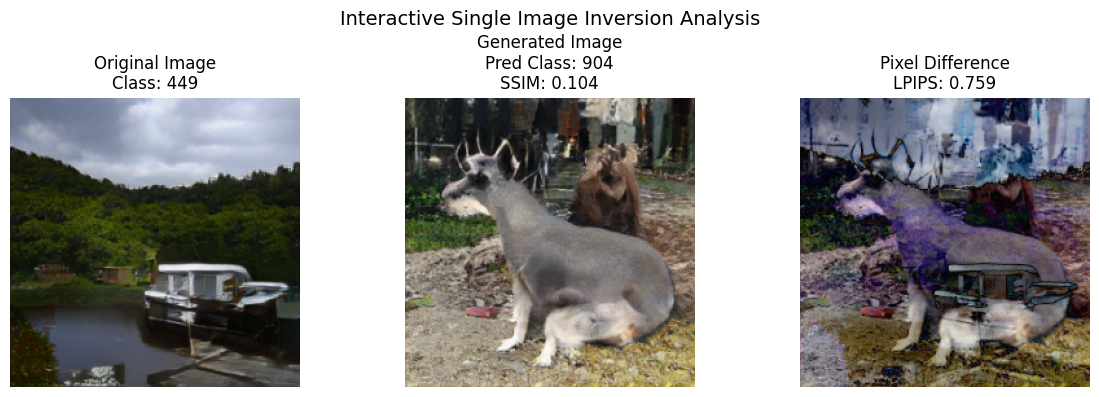


Single image analysis complete!
This image achieved SSIM: 0.104, LPIPS: 0.759


In [18]:
# Quick single image test - Run this for a detailed analysis of one image
print("Running interactive single image inversion...")
try:
    single_metrics = interactive_single_image_inversion()
    print(f"\nSingle image analysis complete!")
    print(f"This image achieved SSIM: {single_metrics['SSIM']:.3f}, LPIPS: {single_metrics['LPIPS']:.3f}")
except Exception as e:
    print(f"Error in single image inversion: {e}")
    print("Make sure the training has completed and models are loaded!")